In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from dataset_func import remap_u_from_sim_grid
from dataset_func import get_X_from_sim_grid
from tools import heatmaps_from_one_sample
from tools import filter_by_feature_range
from gen_plate_img import gen_plate_img

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))  

True
NVIDIA GeForce RTX 2060


In [3]:
#import data

sim_grid_path = r"C:\Users\Antoine\Documents\master\PA\abacus\sim_plaque\ANNs\datasets\20250407125758"

X = get_X_from_sim_grid(sim_grid_path, ["distances"])
y, invalid_results = remap_u_from_sim_grid(sim_grid_path, resolution=24)
X = np.delete(X, invalid_results, axis=0)

print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")

0/200 done
1/200 done
2/200 done
3/200 done
4/200 done
5/200 done
6/200 done
7/200 done
8/200 done
9/200 done
10/200 done
11/200 done
12/200 done
13/200 done
14/200 done
15/200 done
16/200 done
17/200 done
18/200 done
19/200 done
20/200 done
21/200 done
22/200 done
23/200 done
24/200 done
25/200 done
26/200 done
27/200 done
28/200 done
29/200 done
30/200 done
31/200 done
32/200 done
33/200 done
34/200 done
35/200 done
36/200 done
37/200 done
38/200 done
39/200 done
40/200 done
41/200 done
42/200 done
43/200 done
44/200 done
45/200 done
46/200 done
47/200 done
48/200 done
49/200 done
50/200 done
51/200 done
52/200 done
53/200 done
54/200 done
55/200 done
56/200 done
57/200 done
58/200 done
59/200 done
60/200 done
61/200 done
62/200 done
63/200 done
64/200 done
65/200 done
66/200 done
67/200 done
68/200 done
69/200 done
70/200 done
71/200 done
72/200 done
73/200 done
74/200 done
75/200 done
76/200 done
77/200 done
78/200 done
79/200 done
80/200 done
81/200 done
82/200 done
83/200 done
84

In [4]:
print(X.shape)


X_images = np.array([gen_plate_img(int(i)) for i in X[:]])
X_images = np.moveaxis(X_images,-1,1)
X_images = X_images[:,0,:,:]
X_images = np.expand_dims(X_images, axis=1)

print(X_images.shape)

(200, 1)
(200, 1, 400, 400)


C:\Users\Antoine\AppData\Local\Temp\ipykernel_30356\233779603.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_images = np.array([gen_plate_img(int(i)) for i in X[:]])


In [5]:
#add canal dim y for the CNN
y_expanded = np.expand_dims(y, axis=1)
print(y_expanded.shape)

(200, 1, 24, 24)


In [7]:
#normalisation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#scaler_X = MinMaxScaler()
#X_scaled = scaler_X.fit_transform(X_images)
X_scaled = X_images

y_scaled = np.abs(y_expanded)


print(f"X_scaled shape : {X_scaled.shape}")
print(f"y_scaled shape : {y_scaled.shape}")

print(X_scaled)

X_scaled shape : (200, 1, 400, 400)
y_scaled shape : (200, 1, 24, 24)
[[[[100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   ...
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]]]


 [[[100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   ...
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]]]


 [[[100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   ...
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]]]


 ...


 [[[100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   ...
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]]]


 [[[100 100 100 ... 100 100 100]
   [100 100 100 ... 100 100 100]
   [100 100 100 ... 1

In [8]:
#to tenseur
X_tenseur = torch.from_numpy(X_scaled.astype(np.float32))
y_tenseur = torch.from_numpy(y_scaled.astype(np.float32))
X_size = X.shape[1]
y_size = y.shape[1]

print(X_tenseur.shape)
print(y_tenseur.shape)

torch.Size([200, 1, 400, 400])
torch.Size([200, 1, 24, 24])


In [9]:

# train 0.8, test 0.1, val 0.1
X_train, X_temp, y_train, y_temp = train_test_split(X_tenseur, y_tenseur, test_size=0.2, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)

print(f"X_train shape : {X_train.shape}")
print(f"y_train shape : {y_train.shape}")
print("\n")
print(f"X_val shape : {X_val.shape}")
print(f"y_val shape : {y_val.shape}")
print("\n")
print(f"X_test shape : {X_test.shape}")
print(f"y_test shape : {y_test.shape}")

X_train shape : torch.Size([160, 1, 400, 400])
y_train shape : torch.Size([160, 1, 24, 24])


X_val shape : torch.Size([20, 1, 400, 400])
y_val shape : torch.Size([20, 1, 24, 24])


X_test shape : torch.Size([20, 1, 400, 400])
y_test shape : torch.Size([20, 1, 24, 24])


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2, stride=1, padding=1),  # 400x400 -> 400x400
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 400 -> 200
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 200 -> 200
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 200 -> 100
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 100 -> 100
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 100 -> 50
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 50 -> 50
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 50 -> 25

            nn.Conv2d(64, 1, kernel_size=2),  # 25 -> 24
        )
        
    def forward(self, x):
        return self.conv_layers(x)


In [11]:
#test output shape
from torchsummary import summary
test_model = CNN().cpu()
summary(test_model, input_size=(1,400,400), device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 401, 401]              80
              ReLU-2         [-1, 16, 401, 401]               0
         MaxPool2d-3         [-1, 16, 200, 200]               0
            Conv2d-4         [-1, 32, 200, 200]           4,640
              ReLU-5         [-1, 32, 200, 200]               0
         MaxPool2d-6         [-1, 32, 100, 100]               0
            Conv2d-7         [-1, 64, 100, 100]          18,496
              ReLU-8         [-1, 64, 100, 100]               0
         MaxPool2d-9           [-1, 64, 50, 50]               0
           Conv2d-10           [-1, 64, 50, 50]          36,928
             ReLU-11           [-1, 64, 50, 50]               0
        MaxPool2d-12           [-1, 64, 25, 25]               0
           Conv2d-13            [-1, 1, 24, 24]             257
Total params: 60,401
Trainable params: 

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_displacement = CNN().to(device)

#check device
print(next(model_displacement.parameters()).device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model_displacement.parameters(), lr=0.001)

from torch.utils.data import TensorDataset, DataLoader
batch_size = 32 

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


epochs = []
train_losses = []
val_losses = []

num_epochs = 1000
patience = 100  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')  # Initialize with a very high value
epochs_no_improve = 0  # Counter to track epochs without improvement
best_model_weights = None  # To store the best model's weights

for epoch in range(num_epochs):
    # Training Phase
    model_displacement.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward
        pred = model_displacement(batch_X)
        loss = criterion(pred, batch_y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)  # accumulate total loss

    avg_train_loss = epoch_loss / len(train_loader.dataset)

    # Validation Phase
    model_displacement.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # No need to compute gradients during validation
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)            

            pred = model_displacement(batch_X)
            loss = criterion(pred, batch_y)
            val_loss += loss.item() * batch_X.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    epochs.append(epoch+1)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = model_displacement.state_dict()  # Save the best model weights
        epochs_no_improve = 0  # Reset counter if improvement
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Restore the best model weights after training
if best_model_weights is not None:
    model_displacement.load_state_dict(best_model_weights)

cuda:0
Epoch 1/1000 - Train Loss: 25.0454 - Validation Loss: 22.4594
Epoch 2/1000 - Train Loss: 21.8354 - Validation Loss: 22.3309
Epoch 3/1000 - Train Loss: 21.4974 - Validation Loss: 22.2719
Epoch 4/1000 - Train Loss: 21.2188 - Validation Loss: 21.9611
Epoch 5/1000 - Train Loss: 20.9323 - Validation Loss: 21.6152
Epoch 6/1000 - Train Loss: 20.5892 - Validation Loss: 21.2245
Epoch 7/1000 - Train Loss: 20.1680 - Validation Loss: 21.0669
Epoch 8/1000 - Train Loss: 20.0251 - Validation Loss: 20.9155
Epoch 9/1000 - Train Loss: 20.0083 - Validation Loss: 20.9999
Epoch 10/1000 - Train Loss: 19.8263 - Validation Loss: 20.6673
Epoch 11/1000 - Train Loss: 19.6291 - Validation Loss: 20.5169
Epoch 12/1000 - Train Loss: 19.4913 - Validation Loss: 20.4112
Epoch 13/1000 - Train Loss: 19.3966 - Validation Loss: 20.3207
Epoch 14/1000 - Train Loss: 19.3523 - Validation Loss: 20.1954
Epoch 15/1000 - Train Loss: 19.3215 - Validation Loss: 20.0596
Epoch 16/1000 - Train Loss: 19.1961 - Validation Loss: 20

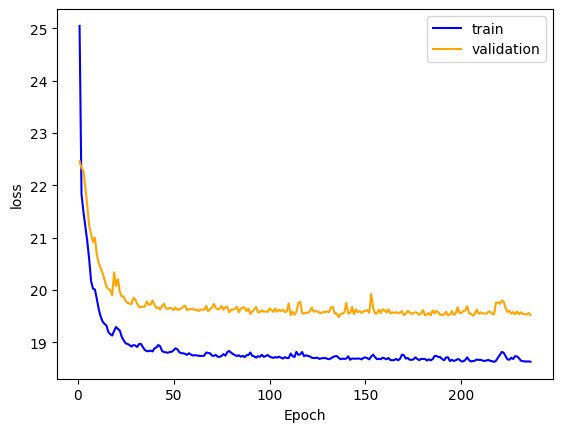

In [13]:
plt.plot(epochs, train_losses, color="blue", label="train")
plt.plot(epochs, val_losses, color="orange", label="validation")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [14]:
# inference MSE score
model_displacement.eval().cpu()

def denorm_y(y_norm, scaler) :
    y_shape = y_norm.shape
    y_transformed = y_norm.reshape(y_norm.shape[0],-1)
    y_denorm = scaler.inverse_transform(y_transformed)
    y_denorm = y_denorm.reshape(y_shape)

    return y_denorm

with torch.no_grad():  
    y_pred = model_displacement(X_test)

mse_loss = nn.MSELoss()
mse_normed = mse_loss(y_pred, y_test)

"""
y_pred_denorm = torch.from_numpy(denorm_y(y_pred))
y_test_denorm = torch.from_numpy(denorm_y(y_test))
mse_denorm = mse_loss(y_pred_denorm, y_test_denorm)
"""
print(f"normed MSE: {mse_normed.item():.4f}")

#print(f"denormed MSE: {mse_denorm.item():.4f}")

normed MSE: 596.4952


torch.Size([20, 1, 24, 24])
(5, 1, 24, 24)


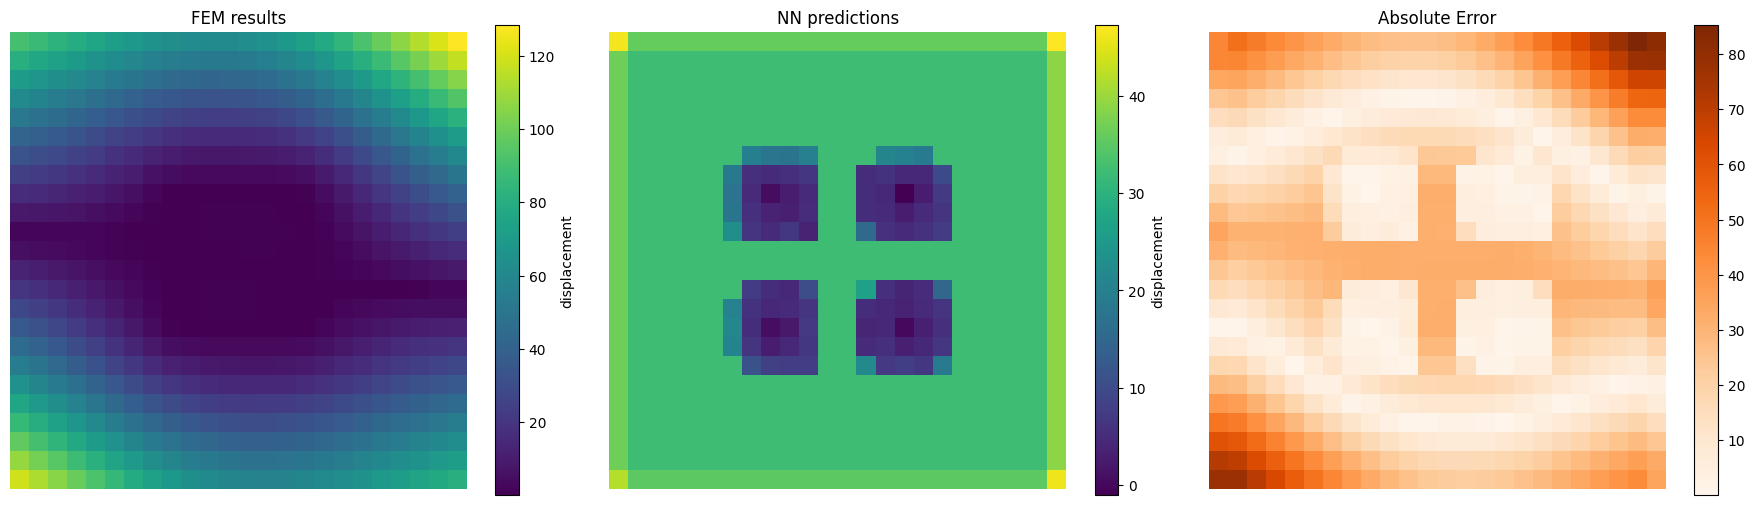

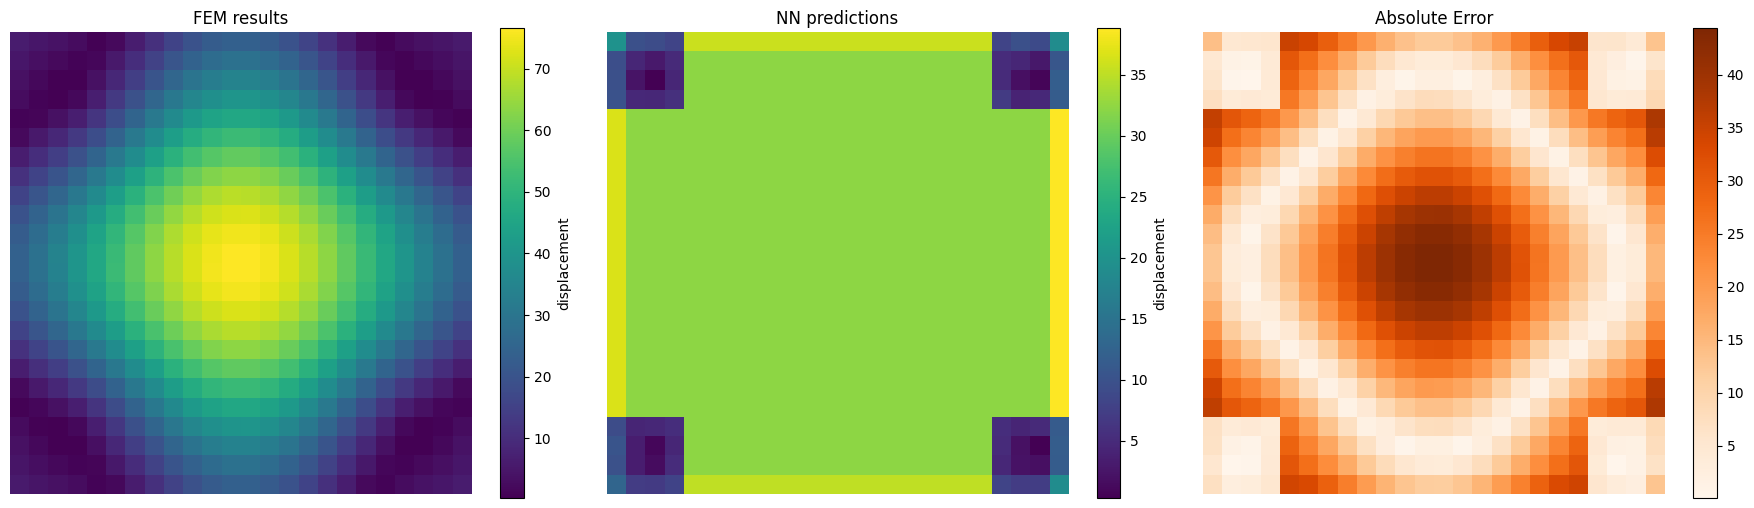

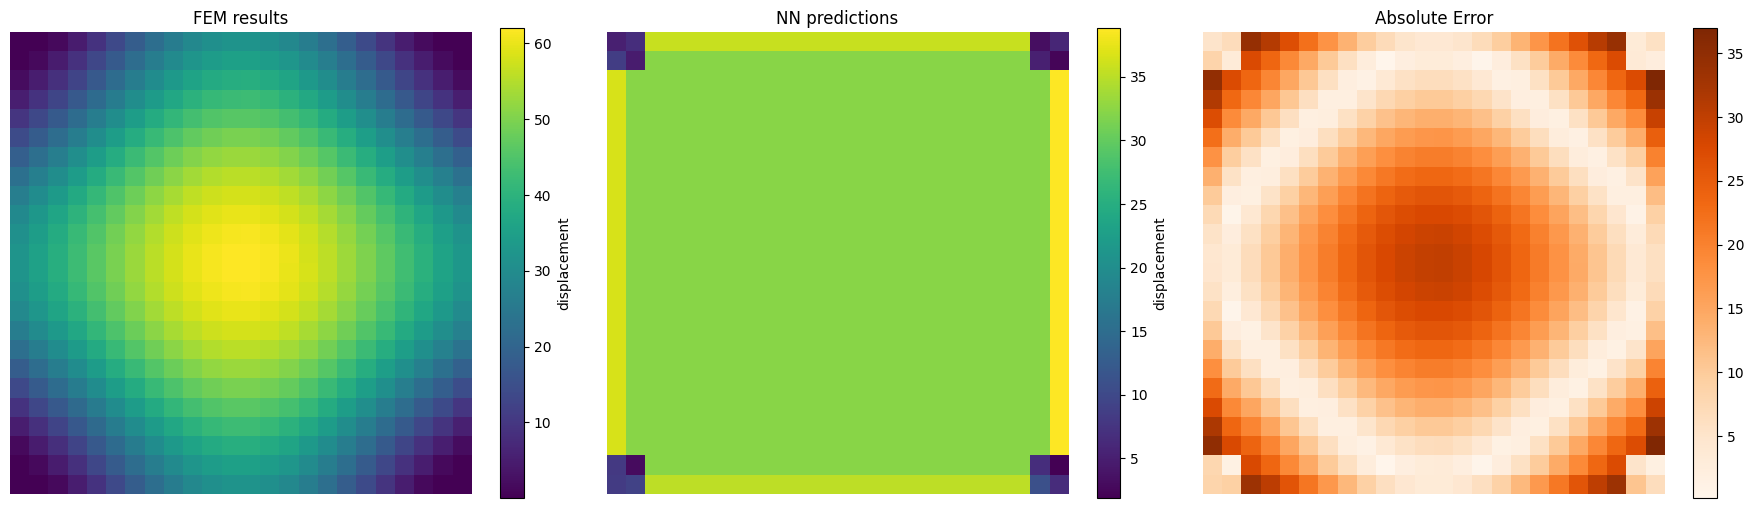

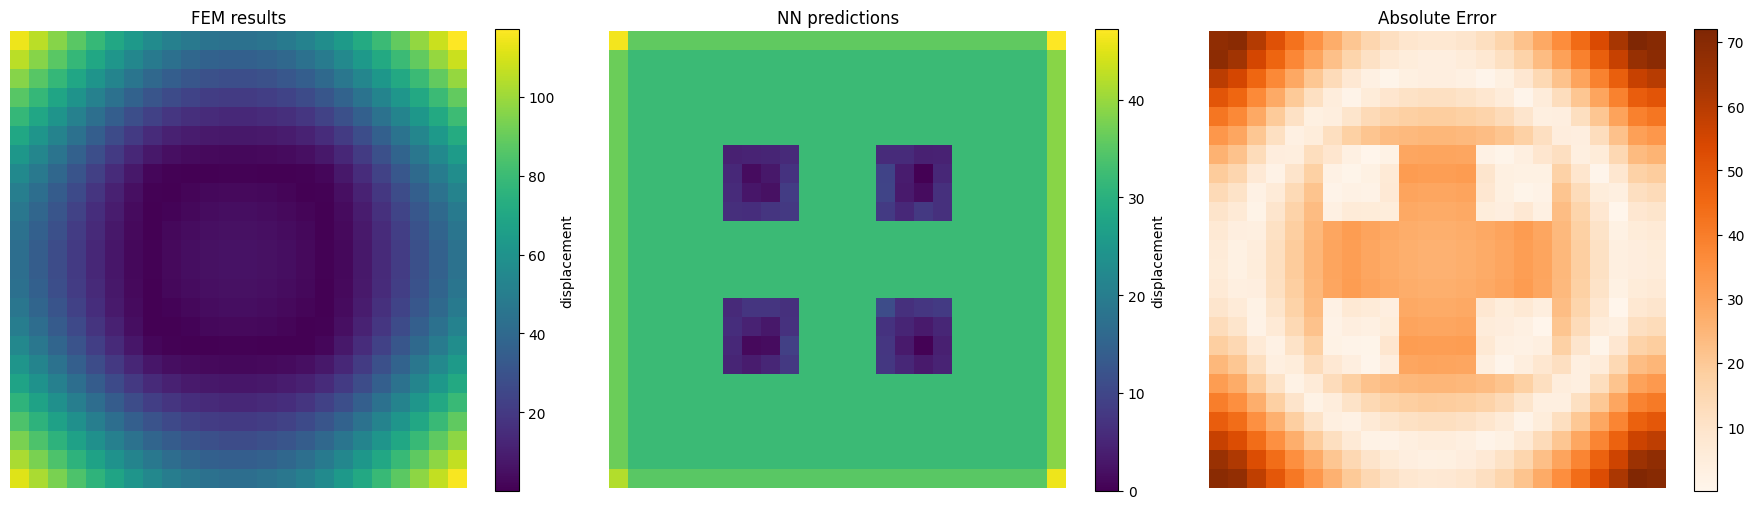

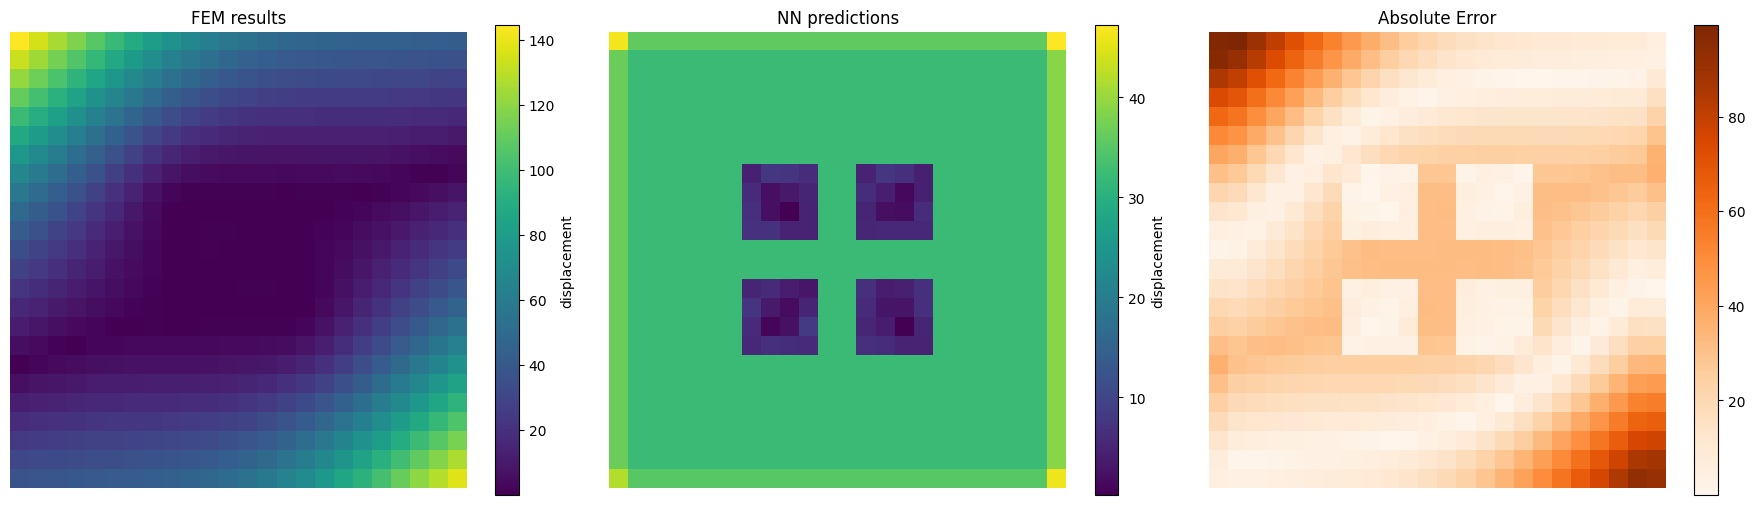

In [15]:
#visualisation inference
map_count = 5
with torch.no_grad():  
    X_test_sample = X_test[:map_count]
    X_test_sample = X_test_sample
    pred_sample = model_displacement(X_test_sample)


#pred = np.squeeze(pred.numpy(), axis=0)
pred_sample = pred_sample.numpy()
true_sample = y_test[:map_count].numpy()

print(pred.shape)
print(true_sample.shape)



"""
pred_denorm = denorm_y(pred_sample)
true_denorm = denorm_y(true_sample)
"""
for i in range(pred_sample.shape[0]):
    heatmaps_from_one_sample(true_sample[i].squeeze(), pred_sample[i].squeeze(), one_scale=False)
